In [134]:
#!/usr/bin/python3

import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

In [135]:
def timescanplot(fname, location, save, show, depletion=False):
    os.chdir(location)
    with open(fname, 'r') as f: file = f.readlines()
    
    skip = [num for num, line in enumerate(file) if 'ALL:' in line.split()]
    iterations = np.array([int(i.split()[-1].strip()) for i in file if '#mass' in i.split()])
    length = len(iterations)

    data = np.genfromtxt(fname, skip_header = skip[0]+1)

    cycle = int(len(data)/iterations.sum())
    time = data[:,1][:cycle]

    temp, temp1, temp2, mass, counts = [], [], [], [], []
    k = 0
    for i in range(len(iterations)):
        j = iterations[i]*cycle
        mass.append(data[:,0][k])
        counts.append(data[:,2][k:k+j])
        k += j
        
        for c in range(cycle):
            for l in range(iterations[i]):
                temp.append(counts[i][(l*cycle)+c])
            temp1.append(temp)
            temp = []
        temp2.append(temp1)
        temp1 = []
        
    mean = [[np.array(temp2[i][j]).mean() for j in range(cycle)]for i in range(length)]
    error = [[(np.array(temp2[i][j]).std()/np.sqrt(iterations[i])) for j in range(cycle)]for i in range(length)]
    mass, mean, error = np.array(mass), np.array(mean), np.array(error)

    if depletion: return mass, iterations, mean, error, time

    plt.figure(figsize=(15,5), dpi=100)

    for i in range(length):
        lg = "%i:%i"%(mass[i], iterations[i])
        plt.errorbar(time, mean[i],error[i],fmt='.-', label = lg)
        
    plt.title('Time Scan plot for %s'%fname)
    plt.xlabel('Time (ms)')
    plt.ylabel('Counts')
    plt.legend()
    plt.tight_layout()

    if save: plt.savefig(fname.split('.')[0]+'.png')
    if show: plt.show()
    
    plt.close()

In [142]:
def func(t, A, k):
    return A*(1-np.exp(-k*t))


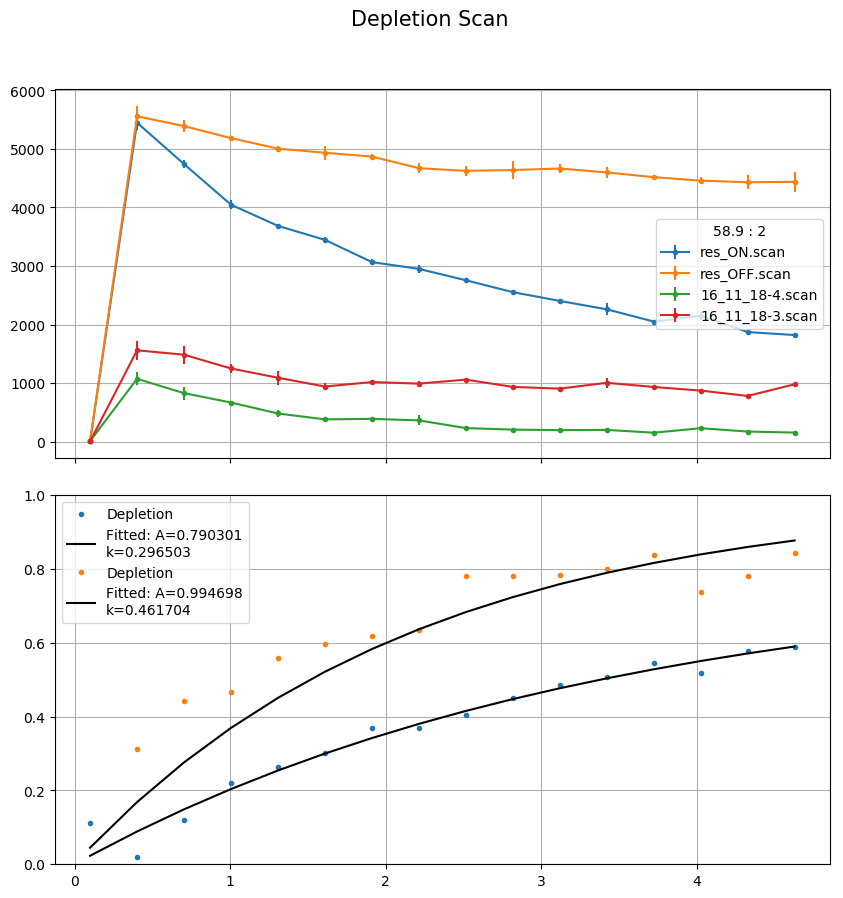

In [151]:
def depletionPlot(files, location, save, show):
    os.chdir(location)
    
    plt.rcParams['figure.figsize'] = (10,10)
    plt.rcParams['figure.dpi'] = 100
    
    fig, axs = plt.subplots(2, sharex=True)
    
    plt.subplots_adjust(top=0.9, hspace=0.1)
    plt.suptitle('Depletion Scan' ,fontsize=15)
    
    full = []
    
    for f in files:
        
        mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
        time = time/1000
        x, y = time, mean[0]
        
        axs[0].errorbar(time, mean[0],yerr=error[0], fmt='.-', label=f)
                
        temp = mean[0]
        full.append(temp)
    
    for i in range(0, len(full), 2):
        
        depletion = 1-(full[i]/full[i+1])
        pop, popc = curve_fit(func, time, depletion)
    
        y_fit = func(time, *pop)
        axs[1].plot(time, depletion,'.', label = 'Depletion')
        axs[1].plot(time, y_fit, 'k', label = 'Fitted: A=%f\nk=%f'%(pop[0], pop[1]))
    
    axs[1].set_ylim(ymin=0,ymax=1)
    
    axs[0].legend(title='%s : %s'%(mass[0], iterations[0]))
    axs[1].legend()
    
    for ax in axs.flat:
        ax.grid(True)

    if save: plt.savefig('depletion.png')
    if show: plt.show()
    plt.tight_layout()
    plt.close()

files = ['16_11_18-4.scan', '16_11_18-3.scan']
files1 = ['res_ON.scan', 'res_OFF.scan', '16_11_18-4.scan', '16_11_18-3.scan']
depletionPlot(files1, location, save, show)

In [132]:
for i in range(0, 4, 2):
    print(i)

0
2


In [50]:
location = r'D:\FELion-Spectrum-Analyser\testing\_datas'
save = False
show = True

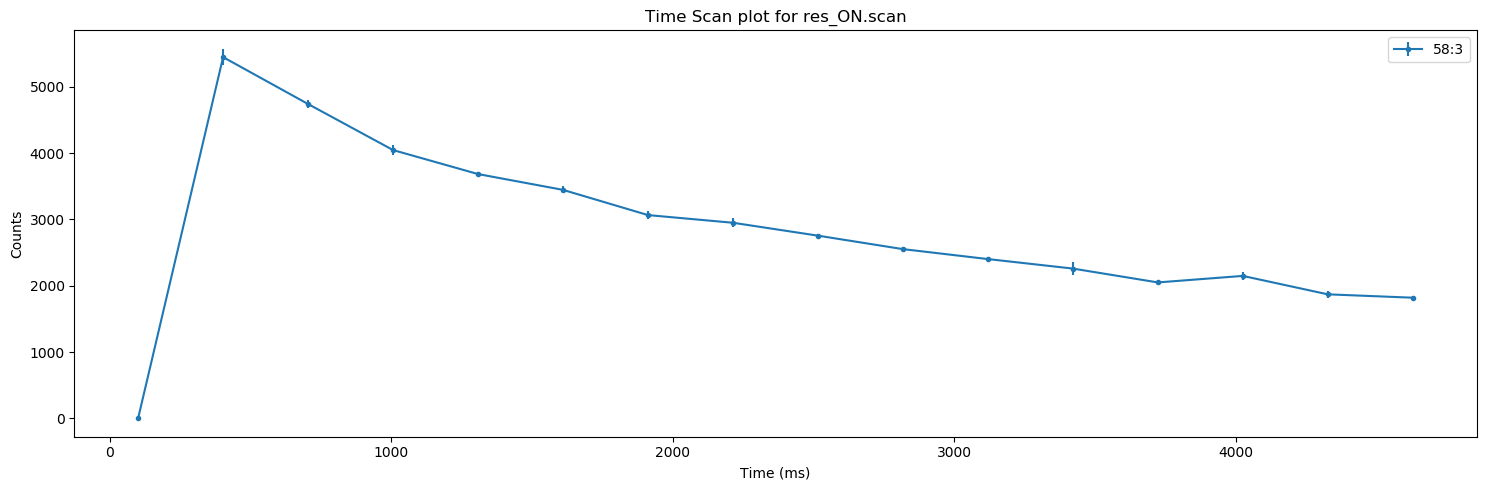

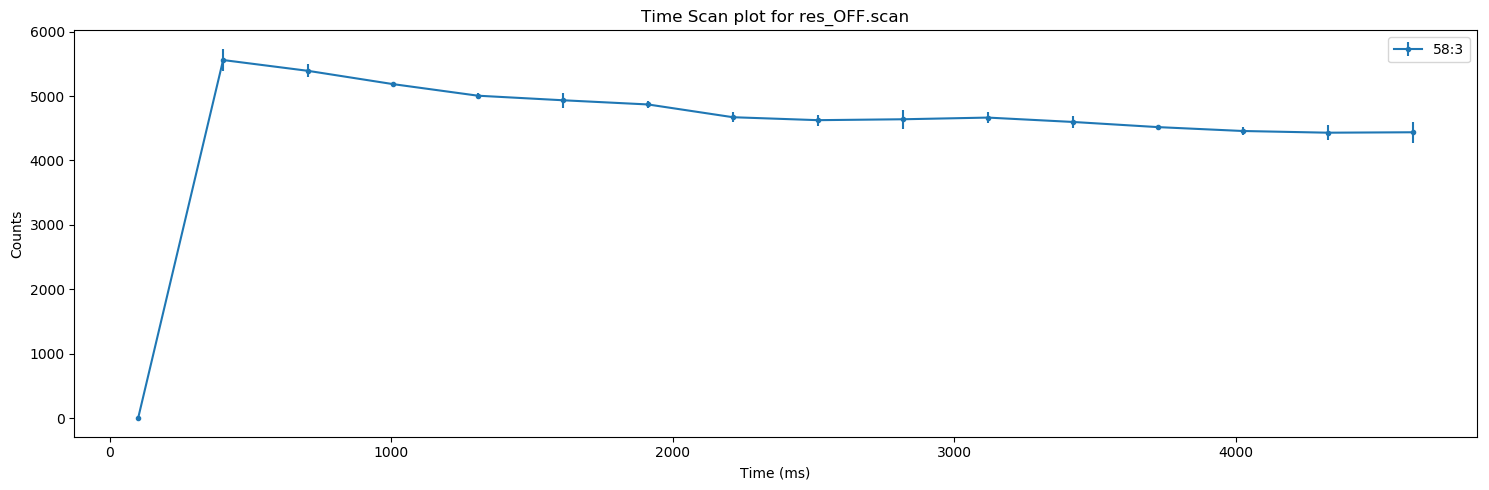

In [147]:
timescanplot('res_ON.scan', location, save, show)
timescanplot('res_OFF.scan', location, save, show)

In [30]:
np.exp(0)

1.0